## Result Analysis I

In [1]:
from glob import glob
import json
import os
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
report_files = glob('reports2/*.json')
print(f"Number of report files: {len(report_files)}")

Number of report files: 703


In [3]:
protein_to_uniprot = json.load(open('protein_to_uniprot.json', 'r'))
uniprot_to_protein = json.load(open('uniprot_to_protein_name.json', 'r'))

In [4]:
model_names= []

In [5]:
metrics = ['accuracy', 'f1_score', 'cohen_kappa', 'mcc']
models = ['xgb', 'rf', 'svc', 'mlp']
data_metrics = ['train_count', 'test_count', 'actives_count', 'decoys_count']
report = dict()

for _file in report_files:
    # Strip the model name
    _dir, _model_name = os.path.split(_file)
    model_name = os.path.splitext(_model_name)[0][:6]
    
    # Load the dictionary
    _dict = json.load(open(_file, 'r'))
    #model_name = _dict['xgb']['uniprot_id']
    model_names.append(model_name)
    
    # Extract the metrics
    _report = [round(_dict[model][metric], 4) for model in models for metric in metrics]
    
    # Find the best model
    # Use cohen kappa, if not available then use f1 score
    scores = np.array([_dict[model]['cohen_kappa'] for model in models])
    best_metric = 'cohen_kappa'
    if 0 in scores:
        scores = np.array([_dict[model]['f1_score'] for model in models])
        best_metric = 'f1_score'
        
    best_model = models[np.argmax(scores)]
    best_score = round(np.max(scores), 4)
    _data_info = [_dict['xgb']['data_info'][c] for c in data_metrics]
    report[model_name] = _report + _data_info + [best_model, best_metric, best_score]
    #break

report_df = pd.DataFrame.from_dict(report, orient='index')
report_df.columns = [f"{model}_{metric}" for model in models for metric in metrics] + data_metrics + ['best_model', 'best_metric', 'best_score']

In [6]:
report_df.head(5)

,xgb_accuracy,xgb_f1_score,xgb_cohen_kappa,xgb_mcc,rf_accuracy,rf_f1_score,rf_cohen_kappa,rf_mcc,svc_accuracy,svc_f1_score,...,mlp_f1_score,mlp_cohen_kappa,mlp_mcc,train_count,test_count,actives_count,decoys_count,best_model,best_metric,best_score
P09038,0.9924,0.9923,0.9524,0.9535,0.9924,0.9923,0.9524,0.9535,1.0000,1.0000,...,0.9923,0.9524,0.9535,528,132,60,600,svc,cohen_kappa,1.0000
P04818,0.9937,0.9936,0.9614,0.9616,0.9968,0.9968,0.9807,0.9809,0.9937,0.9937,...,0.9936,0.9608,0.9616,2534,634,288,2880,rf,cohen_kappa,0.9807
Q16832,0.9296,0.9057,0.2680,0.3934,0.9859,0.9853,0.9015,0.9059,0.9718,0.9718,...,0.9853,0.9015,0.9059,281,71,32,320,rf,cohen_kappa,0.9015
P00734,0.9908,0.9908,0.9792,0.9793,0.9890,0.9889,0.9751,0.9751,0.9761,0.9761,...,0.9908,0.9793,0.9793,6516,1629,2715,5430,mlp,cohen_kappa,0.9793
O00408,0.9964,0.9962,0.9263,0.9281,0.9980,0.9980,0.9612,0.9619,0.9989,0.9989,...,0.9977,0.9563,0.9565,14267,3567,482,17352,svc,cohen_kappa,0.9786


In [7]:
report_df.to_csv('Report2.csv')

best_model
mlp    114
rf     238
svc    155
xgb    196
dtype: int64


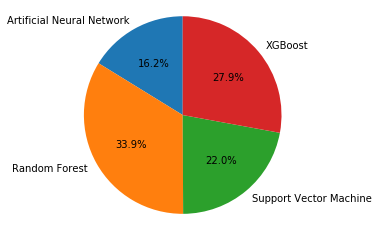

In [8]:
count = report_df.groupby('best_model').size()
print(count)
fig1, ax1 = plt.subplots()
ax1.pie(count, 
        autopct = '%1.1f%%',
        startangle = 90,
        labels = ['Artificial Neural Network', 'Random Forest', 'Support Vector Machine', 'XGBoost'])
ax1.axis('equal')
plt.savefig('plots/model_pie', dpi=300)
plt.show()

In [9]:
report_df.groupby('best_metric').size()

best_metric
cohen_kappa    703
dtype: int64

### Results Analysis II: Count number of models developed for each protein type

In [10]:
# Load Report file
rdf = pd.read_csv('Report2.csv', index_col = 0)
rdf.head(3)

,xgb_accuracy,xgb_f1_score,xgb_cohen_kappa,xgb_mcc,rf_accuracy,rf_f1_score,rf_cohen_kappa,rf_mcc,svc_accuracy,svc_f1_score,...,mlp_f1_score,mlp_cohen_kappa,mlp_mcc,train_count,test_count,actives_count,decoys_count,best_model,best_metric,best_score
P09038,0.9924,0.9923,0.9524,0.9535,0.9924,0.9923,0.9524,0.9535,1.0000,1.0000,...,0.9923,0.9524,0.9535,528,132,60,600,svc,cohen_kappa,1.0000
P04818,0.9937,0.9936,0.9614,0.9616,0.9968,0.9968,0.9807,0.9809,0.9937,0.9937,...,0.9936,0.9608,0.9616,2534,634,288,2880,rf,cohen_kappa,0.9807
Q16832,0.9296,0.9057,0.2680,0.3934,0.9859,0.9853,0.9015,0.9059,0.9718,0.9718,...,0.9853,0.9015,0.9059,281,71,32,320,rf,cohen_kappa,0.9015


In [11]:
# Select columns with information about best models
rdf = rdf[['best_model', 'best_metric', 'best_score']]
rdf.head(3)

,best_model,best_metric,best_score
P09038,svc,cohen_kappa,1.0000
P04818,rf,cohen_kappa,0.9807
Q16832,rf,cohen_kappa,0.9015


In [12]:
# Load json file containing the uniprot ids and their corresponding family name
with open('uniprot_to_family_name.json') as json_file:
    data = json.loads(json_file.read())


In [13]:
# Create list of family name of each uniprot
family = []
for i in range(len(rdf)):
    uniprot = rdf.index[i]
    for key in data.keys():
        if uniprot in data[key]:
            family.append(key)
    else:
        continue

In [14]:
# Insert the family info to existing dataframe.
rdf.insert(0,'protein_family',family)
rdf.head(3)

,protein_family,best_model,best_metric,best_score
P09038,Other,svc,cohen_kappa,1.0000
P04818,Enzyme,rf,cohen_kappa,0.9807
Q16832,Kinase,rf,cohen_kappa,0.9015


In [15]:
# write csv file containing uniprot id, protein family, best model name, best metric and best score
rdf.to_csv('models_with_family_name.csv', index = False)

In [16]:
# Group by best models
ndf = pd.DataFrame({'best_model':list(rdf['best_model']), 'protein_family':list(rdf['protein_family'])})#, 'uniprot':list(r3df['uniprot']), 'best_metric':list(r3df['best_metric']), 'best_score':list(r3df['best_score'])})

In [17]:
# make list of grouped protein families
group_df =ndf.groupby('best_model')['protein_family'].apply(list)
group_df

best_model
mlp    [Enzyme, Enzyme, Enzyme, GPCR, NR, Enzyme, TF;...
rf     [Enzyme, Kinase, Transporter, Epigenetic, GPCR...
svc    [Other, Enzyme, Kinase, Enzyme, Enzyme, Enzyme...
xgb    [GPCR, Enzyme, TF, GPCR, GPCR, Enzyme, Enzyme,...
Name: protein_family, dtype: object

In [18]:
group_df = ndf.groupby('best_model')['protein_family'].apply(list).reset_index(name='protein_family')

In [19]:
group_df

,best_model,protein_family
0,mlp,"[Enzyme, Enzyme, Enzyme, GPCR, NR, Enzyme, TF;..."
1,rf,"[Enzyme, Kinase, Transporter, Epigenetic, GPCR..."
2,svc,"[Other, Enzyme, Kinase, Enzyme, Enzyme, Enzyme..."
3,xgb,"[GPCR, Enzyme, TF, GPCR, GPCR, Enzyme, Enzyme,..."


In [20]:
# for i in range(len(group_df)):
#     print(set(group_df['protein_family'][i]))

In [21]:
# Count models of each model type and protein type
models= {}
protein_fam = ['Kinase', 'Transporter', 'Epigenetic', 'IC', 'Other', 'NR', 'Enzyme', 'GPCR', 'TF; Epigenetic', 'TF']
for f in range(len(group_df)):
    name = group_df['best_model'][f]
    models_freq  = {}
    for p in protein_fam:
        family_list = group_df['protein_family'][f]
        count = family_list.count(p)
        models_freq[p] = count
    models[name] = models_freq
models

{'mlp': {'Kinase': 26,
  'Transporter': 0,
  'Epigenetic': 5,
  'IC': 6,
  'Other': 5,
  'NR': 2,
  'Enzyme': 44,
  'GPCR': 25,
  'TF; Epigenetic': 1,
  'TF': 0},
 'rf': {'Kinase': 40,
  'Transporter': 5,
  'Epigenetic': 13,
  'IC': 17,
  'Other': 31,
  'NR': 7,
  'Enzyme': 82,
  'GPCR': 42,
  'TF; Epigenetic': 0,
  'TF': 1},
 'svc': {'Kinase': 38,
  'Transporter': 4,
  'Epigenetic': 6,
  'IC': 4,
  'Other': 19,
  'NR': 6,
  'Enzyme': 54,
  'GPCR': 21,
  'TF; Epigenetic': 1,
  'TF': 2},
 'xgb': {'Kinase': 29,
  'Transporter': 6,
  'Epigenetic': 8,
  'IC': 13,
  'Other': 18,
  'NR': 5,
  'Enzyme': 79,
  'GPCR': 37,
  'TF; Epigenetic': 0,
  'TF': 1}}

In [22]:
# Save ML models and protein types info.
with open('models_family_frequency.json', 'w') as json_file:
  json.dump(models, json_file)
# Save in csv file as well
pd.read_json('models_family_frequency.json').to_csv('models_family_frequency.csv')